In [14]:
# import package
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim import corpora, models, similarities
from cheaters import dctConstr
from collections import Counter

In [15]:
#reading data
df = pd.read_csv("ASRS_2022.csv")

#eliminate stop words
dct = dctConstr(
    stop_words=["i", "you", "a", "but", "in", "of", "this", "no", "was", "to", "for", "it", "at", "the", "and", "we"], 
    ignore_case=True)
for chat in df.narrative.tolist():
    dct.constructor(chat)
    
#eliminate low frequent words    
dct.trimmer(min=10) # a term must occur 10 times or it gets cut

before trim number of terms: 9819
after trim: 2024


Counter({'Aircraft': 437, 'Human Factors': 213, 'Ambiguous': 124, 'Environment - Non Weather Related': 68, 'Procedure': 60, 'Weather': 39, 'Airport': 16, 'ATC Equipment / Nav Facility / Buildings': 14, 'Company Policy': 6, 'Airspace Structure': 6, 'Equipment / Tooling': 4, 'Software and Automation': 3, 'Chart Or Publication': 3, 'MEL': 2, 'Incorrect / Not Installed / Unavailable Part': 2, nan: 2, 'Manuals': 1})


<AxesSubplot:>

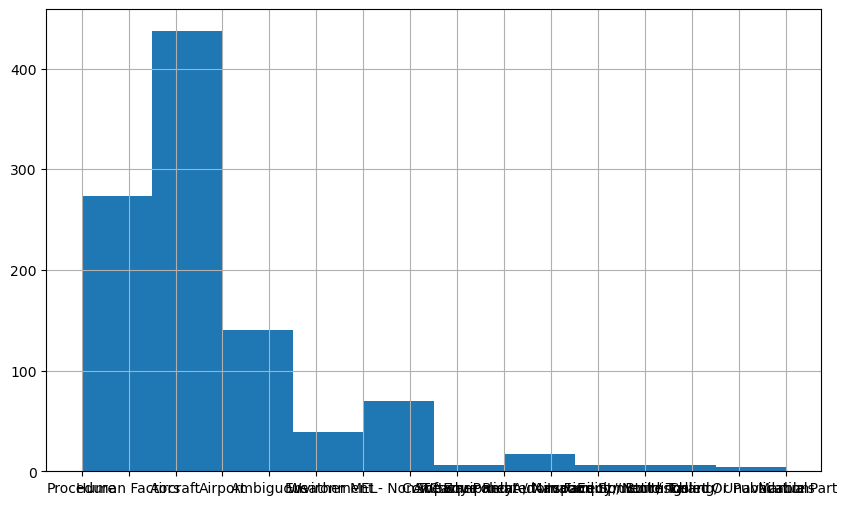

In [4]:
#check the entire distribution in labels
print(Counter(df.label.to_list()))
df.label.hist(figsize=(10, 6),)

<AxesSubplot:>

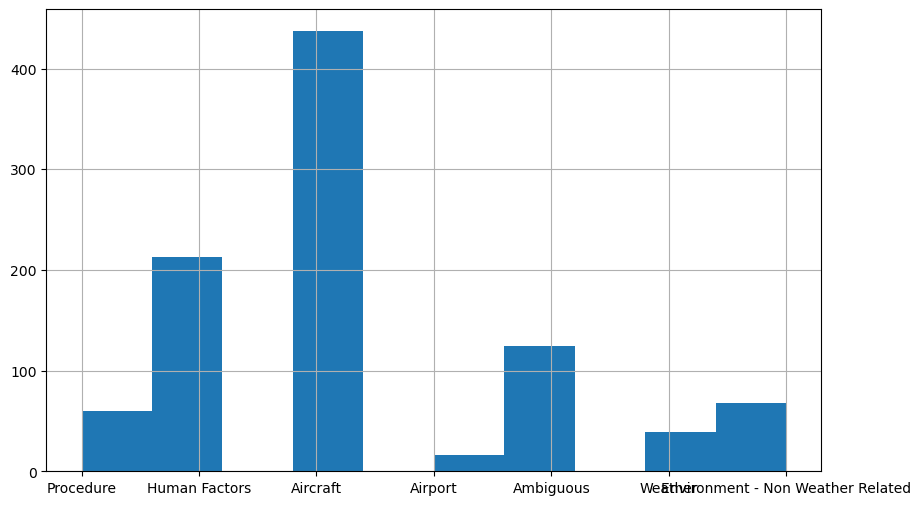

In [5]:
# + data cleaning and eliminate labels where frequncy is less than 10 times
dft = df[df["label"].isin(
    ["Aircraft", "Human Factors", "Ambiguous", "Environment - Non Weather Related", 
     "Procedure", "Weather", "Airport",
    ]
)]
dft.label.hist(figsize=(10, 6),)

In [6]:
#build up a dictionary
corp = dft.narrative.tolist()
bow = [dct(nar) for nar in corp]
tfidf = [dct.tfidf(nar) for nar in corp]
vec = [dct.bow_to_vec(p) for p in bow]  # we are using the plain vector here not tfidf

idx_to_terms = {i:j for j, i in dct.terms.items()} # flip dictionary for reversal
print(f"The corpus consists of {len(vec[0])} terms and {len(corp)} documents")

The corpus consists of 2025 terms and 957 documents


In [7]:
#build up a LSA model
np.random.seed(42) # why is it always 42???
num_topics = 100
lsa = models.LsiModel(bow, id2word=idx_to_terms, num_topics=num_topics)
corpus_lsa = lsa[bow] 

X = np.array([[i[1] for i in p] for p in corpus_lsa])

#print out top 10 words and correlative term weight in the first topic
print(lsa.print_topic(0, 10))

-0.951*"∃" + -0.105*"that" + -0.096*"on" + -0.076*"were" + -0.076*"with" + -0.066*"aircraft" + -0.059*"as" + -0.056*"had" + -0.049*"flight" + -0.047*"not"


In [8]:
#add vectors in lsa to the list
dft["lsa"] = X.tolist()
for i in range(num_topics):
    col_name = "lsa_" + str(i)
    _vec = X[:, i]
    dft[col_name] = _vec

/var/folders/vz/jw81jskx3f71rb397vctsfcr0000gn/T/ipykernel_50086/2386854185.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dft["lsa"] = X.tolist()
/var/folders/vz/jw81jskx3f71rb397vctsfcr0000gn/T/ipykernel_50086/2386854185.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dft[col_name] = _vec
/var/folders/vz/jw81jskx3f71rb397vctsfcr0000gn/T/ipykernel_50086/2386854185.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

In [9]:
# !pip install scikit-learn
# + kmeans clustering，the number of clusters = the number of labels
from sklearn.cluster import KMeans
label_num = 7
km = KMeans(n_clusters= label_num, init='k-means++', max_iter=100, n_init=1)
km.fit(X)  # using the LSA vector
dft["cluster"] = km.predict(X)

# + the least variance means the best cluster
# while there is a problem of over-fitting needs to pay attention if the number of clusters = the number of labels
df_conf = pd.crosstab(dft["label"], dft["cluster"], margins=True)
std_ls = []
for col in df_conf.columns[:-1]:
    std_ls.append(df_conf[col].std())
print(sum(std_ls)/len(std_ls)) 

46.1577283182066


/var/folders/vz/jw81jskx3f71rb397vctsfcr0000gn/T/ipykernel_50086/1281442719.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dft["cluster"] = km.predict(X)
/var/folders/vz/jw81jskx3f71rb397vctsfcr0000gn/T/ipykernel_50086/1281442719.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dft["cluster"] = km.predict(X)


In [10]:
#+crosstab
df_conf = pd.crosstab(dft["label"], dft["cluster"], margins=True)
print(df_conf)

cluster                            0    1   2    3    4  5   6  All
label                                                              
Aircraft                           7  142  20   63  200  0   5  437
Airport                            0    4   0    9    3  0   0   16
Ambiguous                          0   29   7   17   69  0   2  124
Environment - Non Weather Related  0   16   2    9   40  0   1   68
Human Factors                      0   63  18   56   76  0   0  213
Procedure                          1   18   5   19   17  0   0   60
Weather                            0   10   2    9   15  1   2   39
All                                8  282  54  182  420  1  10  957


In [22]:
import plotly.express as px
fig = px.scatter(dft[dft["label"].isin(["Aircraft", "Human Factors"])], x="lsa_0", y="lsa_4", color="label", hover_data=['narrative'], symbol="cluster")
fig.show()

In [23]:
# + explore the data at the topic level more
# we can see, in lsa_4，Human Factors most in the left side，while Aircraft is in the right side
# because each topic and term has positive or negative weight，the label of Human Factors which including more terms of negative weight，Aircraft has the opposite situation
# print out top 10 words and correlative term weight in the lsa_4, determining if the guess is correct we can pick some documents from those labels to verify it.
print(lsa.print_topic(4, 10))

-0.329*"that" + 0.284*"engine" + 0.271*"on" + 0.224*"flight" + -0.168*"approach" + 0.162*"with" + 0.162*"maintenance" + -0.150*"ft" + -0.146*"have" + -0.144*"my"


In [28]:
# +plot the LSA vectors
import plotly.express as px
fig = px.scatter(dft, x="lsa_0", y="lsa_4", color="label", hover_data=['narrative'], symbol="cluster")
fig.show()

In [26]:
#plot tsne
from sklearn.manifold import TSNE
tsne_components = 2
tsne_vec = TSNE(n_components=tsne_components).fit_transform(X)

for i in range(tsne_components):
    col_name = "tsne_" + str(i)
    _vec = tsne_vec[:, i]
    dft[col_name] = _vec

fig = px.scatter(dft, x="tsne_0", y="tsne_1", color="label", hover_data=['narrative'], symbol="cluster")
fig.show()

/Users/odile/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/odile/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

